In [105]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2 as transforms
from torchvision.transforms import functional as F

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from PIL import Image,ImageChops,ImageEnhance
import cv2 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random

In [107]:
def generate_rgb_features(train_images_rgb_path, train_labels_path, test_images_rgb_path, test_labels_path, label_mapping_path, datatype):
    
    '''
    Uses pytorch to load the images and derives the RGB features and stores in OpenCV format for further use.
    Training and testing data only.
    Input ->  Pytorch
    Output -> Pytorch
    '''
    
    # Tranformation to tensor
    transform = transforms.Compose([transforms.ToImage(), transforms.Resize((32,32))])
    
    # Training data loading 
    train_dataset = ImageFolder(root=train_data_path, transform=transform)
    train_dataloader = DataLoader(train_dataset, num_workers=8)
    label_mapping  = train_dataset.classes
    
    if datatype == 'train':
        # Saving training data 
        train_images = []
        train_labels = []
        for image, label in tqdm(train_dataloader):
            train_images.append(image)
            train_labels.append(label)
            
        # Stack and save 
        train_images_rgb= torch.vstack(train_images)
        torch.save(train_images_rgb, train_images_rgb_path )
        
        train_labels = torch.vstack(train_labels)
        torch.save(train_labels, train_labels_path )
        
        torch.save(label_mapping, label_mapping_path)
        
    elif datatype == 'test':
        # Testing data loading 
        test_dataset = ImageFolder(root=test_data_path, transform=transform)
        test_dataloader = DataLoader(test_dataset, num_workers=8)
        
        # Saving testing data 
        test_images = []
        test_labels = []
        for image, label in tqdm(test_dataloader):
            test_images.append(image)
            test_labels.append(label)
        
        # Stack and save 
        test_images_rgb = torch.vstack(test_images)
        torch.save(test_images_rgb, test_images_rgb_path )
        
        test_labels = torch.vstack(test_labels)
        torch.save(test_labels, test_labels_path)
 
    
    

In [109]:
def load_rgb_features():
    
    '''
    Load RGB features from files if present else generate from data
    '''
    
    # Paths
    train_images_rgb_path = f'{data_feature_path}/train_rgb_images.pkl'
    train_labels_path = f'{data_feature_path}/train_labels.pkl'
    test_images_rgb_path = f'{data_feature_path}/test_rgb_images.pkl'
    test_labels_path = f'{data_feature_path}/test_labels.pkl'
    label_mapping_path = f'{data_feature_path}/label_mapping.pkl'
    
    
    if not os.path.isfile(train_images_rgb_path) or not os.path.isfile(train_labels_path):
        print(f"Saved RGB features for training data not available...")
        generate_rgb_features(train_images_rgb_path, train_labels_path, test_images_rgb_path, test_labels_path, label_mapping_path, 'train')
    else:    
        print(f"Loading RGB training data and labels...")    
    train_images_rgb = torch.load(train_images_rgb_path)
    train_labels = torch.load(train_labels_path)
    
    
    
    if not os.path.isfile(test_images_rgb_path) or not os.path.isfile(test_labels_path):
        print(f"Saved RGB features for testing data not available...")
        generate_rgb_features(train_images_rgb_path, train_labels_path, test_images_rgb_path, test_labels_path, label_mapping_path, 'test')
    else:
        print(f"Loading RGB testing data and labels...")  
    test_images_rgb = torch.load(test_images_rgb_path)
    test_labels = torch.load(test_labels_path)
    
    label_mapping = torch.load(label_mapping_path)
    
    return train_images_rgb, train_labels, test_images_rgb, test_labels, label_mapping

In [111]:
def torch_to_cv(images, gray=False):
    
    '''
    Converts images tensor from pytorch tensor to compatible opencv numpy array
    Input : N x C x H x W  shape tensor, where :
        N : Number of images
        C : Channel dimension (RGB)
        H : Height 
        W : Width
    '''
    
    
    #Convert channel from CHW to HWC and RGB to BGR
    
    if gray:
        #Single image, remove channel dimension and convert to numpy
        if len(images.shape) == 2: 
            images_cv = images.squeeze(0).numpy()
        else:
            images_cv = np.array([ img.squeeze(0).numpy() for img in images ])
    
    else:
        print(f'Converting images tensor to BGR OpenCV format...')
        if len(images.shape) == 4:   
            images_cv = images.permute(0,2,3,1).numpy()
            images_cv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images_cv])
        elif len(images.shape) == 3:
            images_cv = images.permute(1,2,0).numpy() 
            images_cv = cv2.cvtColor(images_cv, cv2.COLOR_RGB2BGR)
        
    return images_cv



def cv_to_torch(images, gray=False):
    
    '''
    Converts image from opencv numpy array to compatible pytorch tensor 
    Ensure that input is numpy array.
    Incase of sobel or canny images are gray, set gray=True
    '''
    
     
    #Gray images have channel dimensioin in pytorch but not in OpenCV, Adding the channel dimension from HW to CHW
    if gray:
        
        #Single image, add a dimension for gray images 
        if len(images.shape) == 2:
            images_torch = torch.tensor(images, dtype=torch.uint8).unsqueeze(0)

        elif len(images.shape) == 3:
            #Multiple images
            #images_torch = torch.tensor(np.array([np.array([img]) for img in images]))
            #images_torch = torch.tensor([[img] for img in images],  dtype=torch.uint8)
            images_torch = torch.tensor(images, dtype=torch.uint8).unsqueeze(1)
    else:
        
        #Single Image
        if len(images.shape) == 3:
            images_torch = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
            images_torch = np.transpose(images_torch, (2,0,1))
            images_torch = torch.tensor(images_torch)
        #Convert BGR to RGB and channel from HWC to CHW
        elif len(images.shape) == 4: 
            images_torch = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
            images_torch = np.transpose(images_torch, (0,3,1,2))
            images_torch = torch.tensor(images_torch)
    return images_torch
    

In [113]:
def plot_cv(image, gray=False):
    
    '''
    Display CV2 image using matplotlib
    '''
    if gray:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [115]:
def plot_torch(image, gray=False):
    
    '''
    Display torch image using matplotlib
    '''
    
    if gray:
        plt.imshow(F.to_pil_image(image), cmap='gray')
    else:
        plt.imshow(F.to_pil_image(image))
    plt.show()

In [117]:
def load_rgb_cv(train_images_rgb, test_images_rgb):
    
    '''
    Loads the RGB features in OpenCV format, for later processing.
    Takes in the pytorch image tensor and converts it into OpenCV features and saves it.
    '''
    
    images_rgb_cv_path = f'{data_feature_path}/images_rgb_cv.pkl'
    try:
        print(f"\nLoading RGB type OpenCV features....")
        train_images_rgb_cv, test_images_rgb_cv = torch.load(images_rgb_cv_path)
    except Exception as e:
        print(f"No file present, generating features...")
        train_images_rgb_cv = torch_to_cv(train_images_rgb)
        test_images_rgb_cv = torch_to_cv(test_images_rgb)
        torch.save((train_images_rgb_cv,test_images_rgb_cv), images_rgb_cv_path)
    
    return train_images_rgb_cv, test_images_rgb_cv

In [119]:
def generate_ela(images, quality=95, case='histogram') :
    
    
    '''
    Generating ela features for the training and testing dataset or new data.
    Input in OpenCV BGR format.
    Output in OpenCV BGR format.
    '''
    
    ela_images = []

    print(f'Generating ELA features with quality factor {quality} and enhancement using {case}...')
    
    
    ### Case for dealing with single CV BGR images ###
    single = False
    if len(images.shape) == 3 :
        images = [images]
        single = True
    
    for img in tqdm(images):
        
        # Saving in memory instead of disk for faster output
        _, buffer = cv2.imencode('tmp.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, quality])
        diff = cv2.absdiff(img, cv2.imdecode(buffer, cv2.IMREAD_COLOR))
        if case == 'minmax' :
            min_diff = diff.min()
            max_diff = diff.max()
            if max_diff == 0:
                max_diff = 1
            scale = 255.0 / max_diff
            ela_image = cv2.convertScaleAbs(diff, alpha=scale, beta=0)
        
        elif case == 'histogram' :

            #Using HSV according to wiki 
            hsv_image = cv2.cvtColor(diff, cv2.COLOR_BGR2HSV)
            hue, sat, val = cv2.split(hsv_image)
            val_eq = cv2.equalizeHist(val)
            equalized_hsv_image = cv2.merge((hue, sat, val_eq))
            ela_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)
        
        
        ela_images.append(ela_image)
    
    if single:
        return ela_images[0]
    return np.array(ela_images)




def load_ela(train_images_rgb, test_images_rgb, etype, cv=False):
     
    '''
    Helper funtion for feature extraction of training and testing data.
    Load generated ELA features by case and by defaults converts it to pytorch version and return, argument for RAW OpenCV output
    Only for training and testing data.
    Input is in Torch Tensor.
    Output by default is in Torch Tensor.
    '''
    
    ### ELA CV 2 types ###
    images_ela_hist_cv_path = f'{data_feature_path}/images_ela_hist_cv.pkl'
    
    if etype == 'histogram':
        
        ## Histogram ##
        try:
            print(f"\nLoading ELA Histogram type OpenCV features....")
            train_images_ela_hist_cv, test_images_ela_hist_cv = torch.load(images_ela_hist_cv_path)
        except Exception as e:
            print(f"No file present, generating features...")
            train_images_rgb_cv, test_images_rgb_cv = load_rgb_cv(train_images_rgb, test_images_rgb)
            train_images_ela_hist_cv = generate_ela(train_images_rgb_cv, 95, 'histogram')
            test_images_ela_hist_cv = generate_ela(test_images_rgb_cv, 95, 'histogram')
            torch.save((train_images_ela_hist_cv,test_images_ela_hist_cv), images_ela_hist_cv_path)
        
        if cv :
            return train_images_ela_hist_cv, test_images_ela_hist_cv
        else :
            return cv_to_torch(train_images_ela_hist_cv), cv_to_torch(test_images_ela_hist_cv)
            
        
    elif etype == 'minmax':
        
        ## MinMax ##
        images_ela_minmax_cv_path = f'{data_feature_path}/images_ela_minmax_cv.pkl'
        ## Histogram ##
        try:
            print(f"\nLoading ELA MinMax type OpenCV features....")
            train_images_ela_minmax_cv, test_images_ela_minmax_cv = torch.load(images_ela_minmax_cv_path)
        except Exception as e:
            print(f"No file present, generating features...")
            train_images_rgb_cv, test_images_rgb_cv = load_rgb_cv(train_images_rgb, test_images_rgb)
            train_images_ela_minmax_cv = generate_ela(train_images_rgb_cv, 95, 'minmax')
            test_images_ela_minmax_cv = generate_ela(test_images_rgb_cv, 95, 'minmax')
            torch.save((train_images_ela_minmax_cv,test_images_ela_minmax_cv), images_ela_minmax_cv_path)
        
        if cv :
            return train_images_ela_minmax_cv, test_images_ela_minmax_cv
        else :
            return cv_to_torch(train_images_ela_minmax_cv), cv_to_torch(test_images_ela_minmax_cv)
    

In [121]:
def generate_sobel(images, k=3) :
    
    
    '''
    Input OpenCV BGR image
    Output OpenCV GRAYSCALE image
    '''
    
    sobel_images = []
    print(f'Generating Sobel edge features with kernel size {k}x{k}...')
    
    ### Case for dealing with single CV BGR images ###
    single = False
    if len(images.shape) == 3 :
        images = [images]
        single = True
  
        
    for img in tqdm(images):
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Sobel edge detection
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=k)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=k)
        sobel_image = cv2.magnitude(sobel_x, sobel_y)
        
        sobel_images.append(sobel_image)
    
    if single:
        return sobel_images[0]
    return np.array(sobel_images)
    
    
    
def generate_canny(images, low=20, high=200):
    
    
    '''
    Input OpenCV BGR image
    Output OpenCV GRAYSCALE image
    '''
    canny_images = []
    print(f'Generating Canny edge features with low {low} high {high}...')
    
    ### Case for dealing with single CV BGR images ###
    single = False
    if len(images.shape) == 3 :
        images = [images]
        single = True
        
    for img in tqdm(images):
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Canny edge detection
        canny_image = cv2.Canny(gray_image, low, high)
        
        canny_images.append(canny_image)
    
    if single:
        return canny_images[0]
    return np.array(canny_images)


def load_sobel(train_images_rgb, test_images_rgb, cv=False):
    
    
    '''
    Loading pre generated sobel features of trainig and testing data 
    Output by default is converted to pytorch format from the OpenCV format
    '''
    
    ### SOBEL CV ###
    images_sobel_cv_path = f'{data_feature_path}/images_sobel_cv.pkl'
    try:
        print(f"\nLoading Sobel type OpenCV features....")
        train_images_sobel_cv,test_images_sobel_cv = torch.load(images_sobel_cv_path)
    except Exception as e:
        print(f"No file present, generating features...")
        train_images_rgb_cv, test_images_rgb_cv = load_rgb_cv(train_images_rgb, test_images_rgb)
        train_images_sobel_cv = generate_sobel(train_images_rgb_cv)
        test_images_sobel_cv = generate_sobel(test_images_rgb_cv)
        torch.save((train_images_sobel_cv,test_images_sobel_cv), images_sobel_cv_path)
    
    if cv:
        return train_images_sobel_cv, test_images_sobel_cv
    else:
        
        return cv_to_torch(train_images_sobel_cv, gray=True), cv_to_torch(test_images_sobel_cv, gray=True)



def load_canny(train_images_rgb, test_images_rgb, cv=False):
    
    
    '''
    Loading pre generated canny features of trainig and testing data 
    Output by default is converted to pytorch format from the OpenCV format
    '''
    
    ### CANNY CV ###
    images_canny_cv_path = f'{data_feature_path}/images_canny_cv.pkl'
    try:
        print(f"\nLoading Canny type OpenCV features....")
        train_images_canny_cv,test_images_canny_cv = torch.load(images_canny_cv_path)
    except Exception as e:
        print(f"No file present, generating features...")
        train_images_rgb_cv, test_images_rgb_cv = load_rgb_cv(train_images_rgb, test_images_rgb)
        train_images_canny_cv = generate_canny(train_images_rgb_cv)
        test_images_canny_cv = generate_canny(test_images_rgb_cv)
        torch.save((train_images_canny_cv,test_images_canny_cv), images_canny_cv_path)
    
    if cv:
        return train_images_canny_cv, test_images_canny_cv
    else:
        return cv_to_torch(train_images_canny_cv, gray=True), cv_to_torch(test_images_canny_cv, gray=True)
    

In [123]:
def image_plot(train_images, n=3):
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    for i in range(0,3):
        axes[i].imshow(F.to_pil_image(train_images[i]))
        axes[i].axis('off')
    plt.show()

In [125]:
def cnn_model1(ftype, batch_size=128, num_epochs=20):
    
    
    '''
    Load model if already available or generate model.
    ftype -> feature type
    batch size -> batch size used in training the model
    num_epochs -> number of epochs 
    Model is saved for every epoch.
    Model is save in folder model_1_{ftye} as :
    model{model_number}_e{epoch+1}_b{batch_size}.pth'
    '''
    
    model_number = 1
    
    # Loading/Generating RGB by default
    ### RGB ###
    train_images_rgb, train_labels, test_images_rgb, test_labels, label_mapping = load_rgb_features()    
    
    
    
    

    match ftype:
        
        case 'rgb' :
                print(f'Training and testing model with RGB features')
                train_images, test_images = train_images_rgb, test_images_rgb      
        case 'sobel':
                print(f'Training and testing model with sobel edges features')
                train_images, test_images = load_sobel(train_images_rgb, test_images_rgb)
        case 'canny':
                print(f'Training and testing model with canny edges features')
                train_images, test_images = load_canny(train_images_rgb, test_images_rgb)
        case 'ela_hist':
                print(f'Training and testing model with ela enhanced with histogram equalization features')
                train_images, test_images = load_ela(train_images_rgb, test_images_rgb, 'histogram')
        case 'ela_minmax':
                print(f'Training and testing model with ela enhanced with minmax equalization features')
                train_images, test_images = load_ela(train_images_rgb, test_images_rgb, 'minmax')
    
    


    
    
    if ftype in ['sobel','canny']:
        
        ## Convert to 3 channels ##
        ## Multiple images ##
        if len(train_images.shape) == 4:
            dim = 1
        ## Single images ##
        else:               
            dimg = 0
        train_images, test_images = torch.cat([train_images] * 3, dim=dim), torch.cat([test_images] * 3, dim=dim)
    
    #Display feature examples 
    print(f'\nFeature examples :')
    image_plot(train_images, n=3)
   
    # Scaling the RGB values between [0,1] form [0,255]
    train_images = train_images.float() / 255.0
    test_images = test_images.float() / 255.0
    ##mean = torch.mean(train_images, dim=(0, 2, 3))
    ##std = torch.std(train_images, dim=(0, 2, 3))

    
    # Matching dimension like ImageFolder
    train_labels = train_labels.squeeze()
    test_labels = test_labels.squeeze()
    
    #######################   DATALOADING  ####################### 
    train_dataset = TensorDataset(train_images, train_labels)
    test_dataset = TensorDataset(test_images, test_labels)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    #######################   MODEL  #######################
    class CNN(torch.nn.Module):
        
        def __init__(self):
            super(CNN, self).__init__()          
            self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = torch.nn.Linear(128 * 4 * 4, 256)
            self.dropout = torch.nn.Dropout(0.5)
            self.fc2 = torch.nn.Linear(256, 1)
            
            
        def forward(self, x):
            y = torch.nn.functional.relu(self.conv1(x))
            y = self.pool(y)
            y = torch.nn.functional.relu(self.conv2(y))
            y = self.pool(y)
            y = torch.nn.functional.relu(self.conv3(y))
            y = self.pool(y)
            y = y.view(-1, 128 * 4 * 4)
            y = torch.nn.functional.relu(self.fc1(y))
            y = self.dropout(y)
            y = torch.sigmoid(self.fc2(y))
            return y
        
        
        
        
    #######################   TRAIN AND TEST  #######################
    # GPU/CPU and load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN().to(device)
    
    # Definiing loss
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # Storing scores for all the epochs
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cm_plots = []
    c_reports = []
    
    # Train the model
    num_epochs = num_epochs
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0
        
        for images, labels in train_loader:
            
            
            ### TEMP ###
            '''
            if count % 500 == 0:
                print(count)
            count += 1
            '''
            
            # Move batch to GPU if possible 
            images, labels = images.to(device), labels.to(device)
                        
            optimizer.zero_grad()
            
            # Prediction
            outputs = model(images)
            
            # Loss calculation
            loss = criterion(outputs.squeeze(), labels.float())
            
            # Gradient calculation
            loss.backward()
            
            # Backprapogation
            optimizer.step()
            
            ### TEMP ### CHECK AGAIN ###
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss/len(train_loader))
        # Evaluate the model for each epoch 
        model.eval()
        
        predictions = []
        
        count = 0
        with torch.no_grad():
            for images, _ in test_loader:
                
                ### TEMP ###
                '''
                if count % 250 == 0:
                    print(count)
                count += 1
                '''
                
                # Move batch to GPU if possible
                images = images.to(device)
                
                # Prediction 
                outputs = model(images)
                preds = torch.round(outputs)
                predictions.extend(preds.cpu().tolist())
        
        # Convert predictions to numpy array
        predictions = np.array(predictions)
        
        # Calculate scores
        true_labels = test_labels
        # Length of predictions to avoid dropped incomplete batch images
        true_labels = true_labels[:len(predictions)]
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        cm = confusion_matrix(true_labels, predictions)
        cr = classification_report(true_labels, predictions)
        
        
        # Save scores per epoch
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        cm_plots.append(cm)
        c_reports.append(cr)
        
        # Print epoch accuracy 
        print(f"Epoch {epoch+1}, Accuracy: {accuracy}")
        
        # Save the models
        destination  = f'models_{model_number}_{ftype}'
        if not os.path.exists(destination):
            os.mkdir(destination)
        torch.save(model.state_dict(), f'{destination}/model{model_number}_e{epoch+1}_b{batch_size}.pth')
        
    
    
    
    # Save scores
    torch.save([accuracy_scores,precision_scores,recall_scores,f1_scores], f'{destination}/scores_b{batch_size}.pkl')    
    
    
    #### PLOT ####
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.xlim(1, len(losses))  # Set x-axis limits
    plt.xticks(range(1, len(losses) + 1))  # Set ticks for each epoch
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, accuracy_scores, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlim(1, len(accuracy_scores))  # Set x-axis limits
    plt.xticks(range(1, len(accuracy_scores) + 1))  # Set ticks for each epoch
    plt.ylim(0.4, 1)
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    highest_accuracy_index = accuracy_scores.index(max(accuracy_scores))
    print(f'Highest accuracy : {max(accuracy_scores)} at epoch {highest_accuracy_index+1}')
    print(f'Confusion matrix of epoch {highest_accuracy_index+1}:')
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_plots[highest_accuracy_index], display_labels = [0, 1])
    cm_display.plot()
    plt.show()
    print(c_reports[highest_accuracy_index])                                 
    print('\n\n\n\n')
    

2.2.2+cu121
Loading RGB training data and labels...
Loading RGB testing data and labels...
Training and testing model with RGB features

Feature examples :


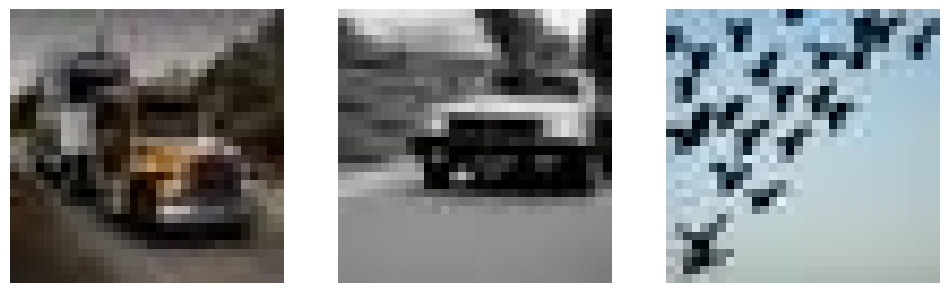

Epoch 1, Loss: 0.29176593002375506
Epoch 1, Accuracy: 0.9220753205128205
Epoch 2, Loss: 0.18772464352403498
Epoch 2, Accuracy: 0.9352463942307693
Epoch 3, Loss: 0.16066192522664077
Epoch 3, Accuracy: 0.936698717948718
Epoch 4, Loss: 0.14477286082853427
Epoch 4, Accuracy: 0.9399038461538461
Epoch 5, Loss: 0.13083385205833617
Epoch 5, Accuracy: 0.9386017628205128
Epoch 6, Loss: 0.12091380482713636
Epoch 6, Accuracy: 0.9387520032051282
Epoch 7, Loss: 0.10742045207266313
Epoch 7, Accuracy: 0.9437600160256411
Epoch 8, Loss: 0.0988399059405591
Epoch 8, Accuracy: 0.9519230769230769
Epoch 9, Loss: 0.0880332837160319
Epoch 9, Accuracy: 0.9513721955128205
Epoch 10, Loss: 0.0790494172529779
Epoch 10, Accuracy: 0.953125
Epoch 11, Loss: 0.07236889638507527
Epoch 11, Accuracy: 0.9513221153846154
Epoch 12, Loss: 0.06189457446732648
Epoch 12, Accuracy: 0.9538762019230769
Epoch 13, Loss: 0.05628548867800172
Epoch 13, Accuracy: 0.9523737980769231
Epoch 14, Loss: 0.05123163754342269
Epoch 14, Accuracy: 0

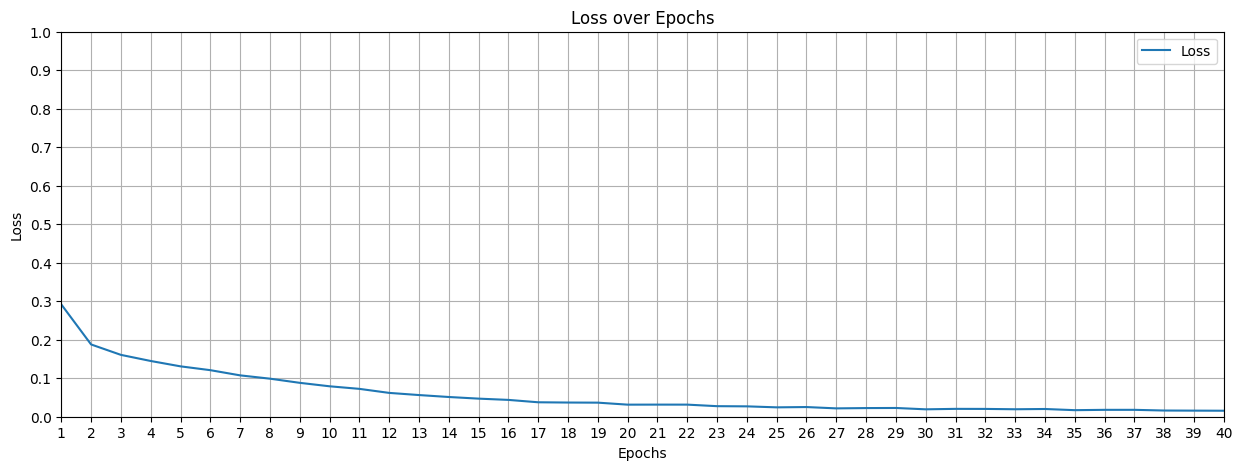

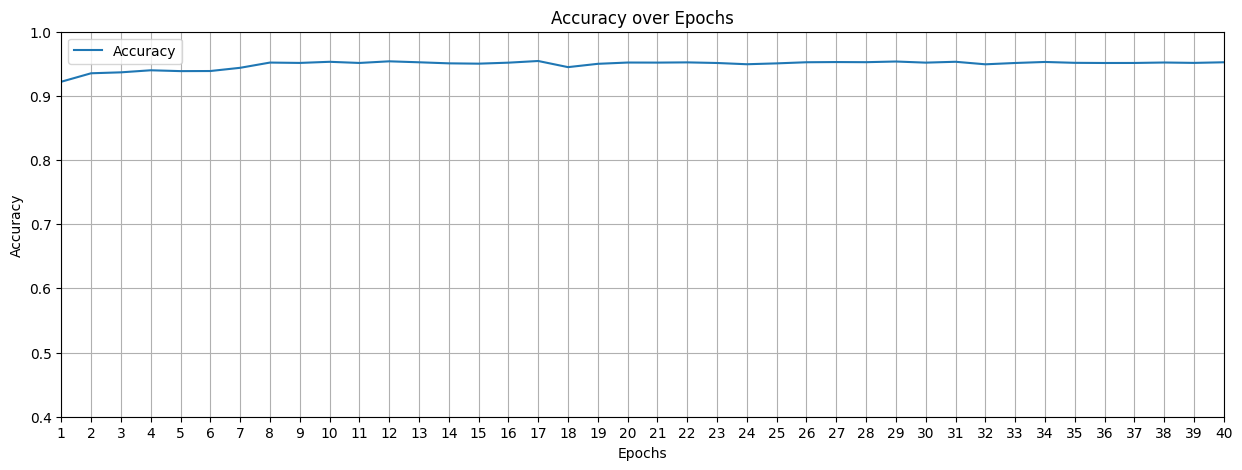

Highest accuracy : 0.9543770032051282 at epoch 17
Confusion matrix of epoch 17:


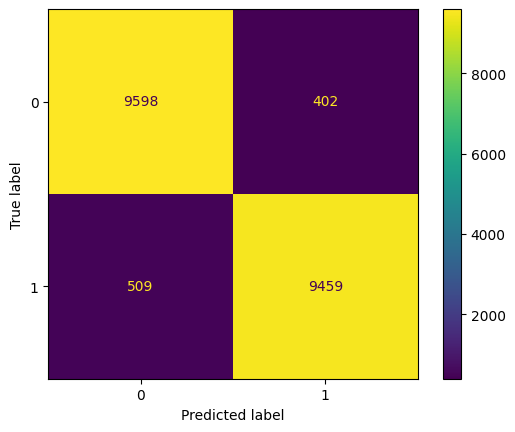

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95      9968

    accuracy                           0.95     19968
   macro avg       0.95      0.95      0.95     19968
weighted avg       0.95      0.95      0.95     19968






Loading RGB training data and labels...
Loading RGB testing data and labels...
Training and testing model with sobel edges features

Loading Sobel type OpenCV features....

Feature examples :


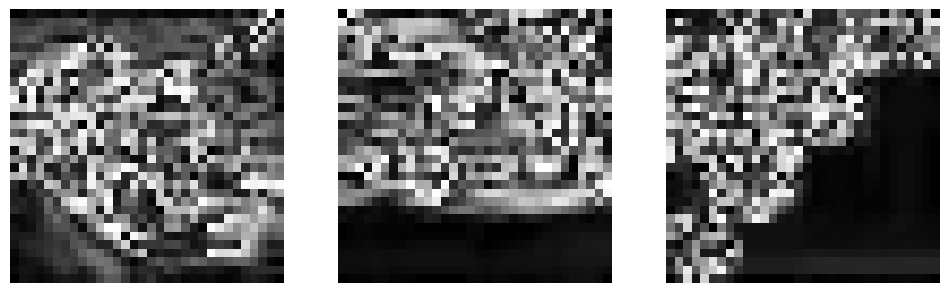

Epoch 1, Loss: 0.5230930594491287
Epoch 1, Accuracy: 0.7910657051282052
Epoch 2, Loss: 0.43362333046489426
Epoch 2, Accuracy: 0.8135016025641025
Epoch 3, Loss: 0.40376849211132326
Epoch 3, Accuracy: 0.8115985576923077
Epoch 4, Loss: 0.38186024079783776
Epoch 4, Accuracy: 0.8319310897435898
Epoch 5, Loss: 0.3632752915961184
Epoch 5, Accuracy: 0.8330328525641025
Epoch 6, Loss: 0.34578377950969946
Epoch 6, Accuracy: 0.8365384615384616
Epoch 7, Loss: 0.3291013685368698
Epoch 7, Accuracy: 0.8420973557692307
Epoch 8, Loss: 0.3159185765685559
Epoch 8, Accuracy: 0.8410456730769231
Epoch 9, Loss: 0.29986295737469243
Epoch 9, Accuracy: 0.8392928685897436
Epoch 10, Loss: 0.28813957492612235
Epoch 10, Accuracy: 0.8359375
Epoch 11, Loss: 0.27201122671327577
Epoch 11, Accuracy: 0.8405949519230769
Epoch 12, Loss: 0.25728028175085976
Epoch 12, Accuracy: 0.8421975160256411
Epoch 13, Loss: 0.2457291226113804
Epoch 13, Accuracy: 0.8393429487179487
Epoch 14, Loss: 0.23253553160364893
Epoch 14, Accuracy: 0

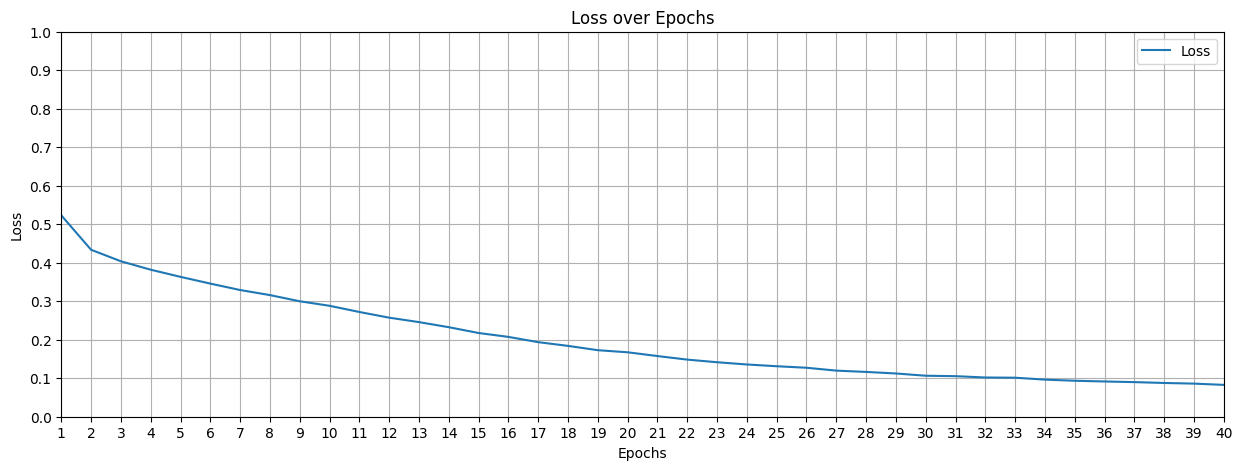

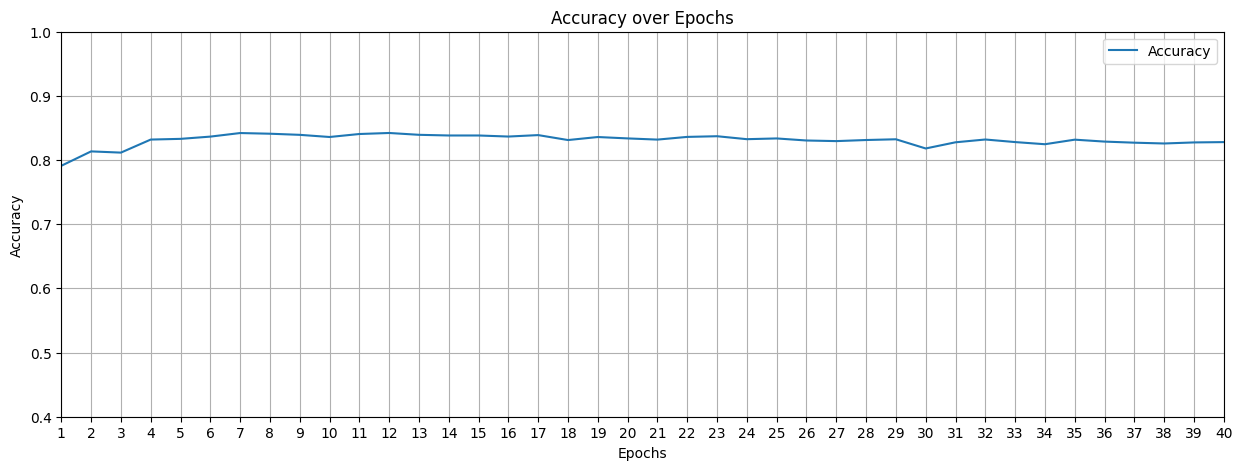

Highest accuracy : 0.8421975160256411 at epoch 12
Confusion matrix of epoch 12:


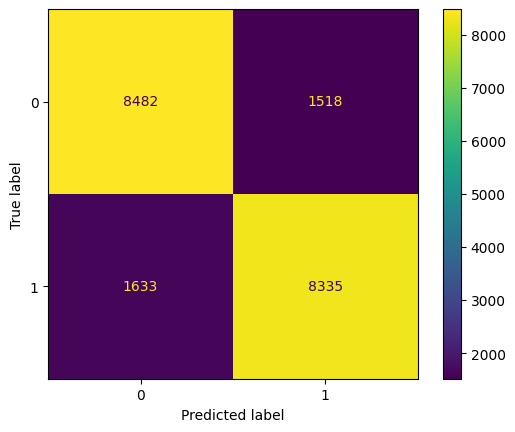

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     10000
           1       0.85      0.84      0.84      9968

    accuracy                           0.84     19968
   macro avg       0.84      0.84      0.84     19968
weighted avg       0.84      0.84      0.84     19968






Loading RGB training data and labels...
Loading RGB testing data and labels...
Training and testing model with canny edges features

Loading Canny type OpenCV features....

Feature examples :


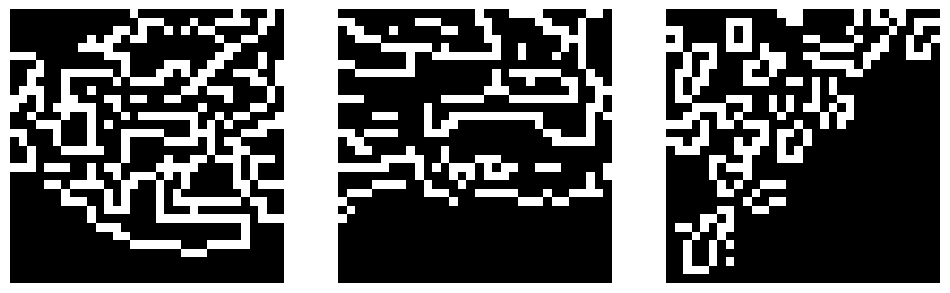

Epoch 1, Loss: 0.5892548484777824
Epoch 1, Accuracy: 0.7269130608974359
Epoch 2, Loss: 0.5337221712522714
Epoch 2, Accuracy: 0.7425881410256411
Epoch 3, Loss: 0.49969306916341893
Epoch 3, Accuracy: 0.7600160256410257
Epoch 4, Loss: 0.4699440136761733
Epoch 4, Accuracy: 0.7649238782051282
Epoch 5, Loss: 0.43787675512127017
Epoch 5, Accuracy: 0.7636217948717948
Epoch 6, Loss: 0.4068213368500088
Epoch 6, Accuracy: 0.7711838942307693
Epoch 7, Loss: 0.37502688186651
Epoch 7, Accuracy: 0.7688802083333334
Epoch 8, Loss: 0.34178417058668736
Epoch 8, Accuracy: 0.7641225961538461
Epoch 9, Loss: 0.310985536012851
Epoch 9, Accuracy: 0.7599659455128205
Epoch 10, Loss: 0.2838145728567651
Epoch 10, Accuracy: 0.7645232371794872
Epoch 11, Loss: 0.25307483879536885
Epoch 11, Accuracy: 0.7652744391025641
Epoch 12, Loss: 0.22879132673277897
Epoch 12, Accuracy: 0.7602163461538461
Epoch 13, Loss: 0.20765286059179625
Epoch 13, Accuracy: 0.7557592147435898
Epoch 14, Loss: 0.188105678541178
Epoch 14, Accuracy:

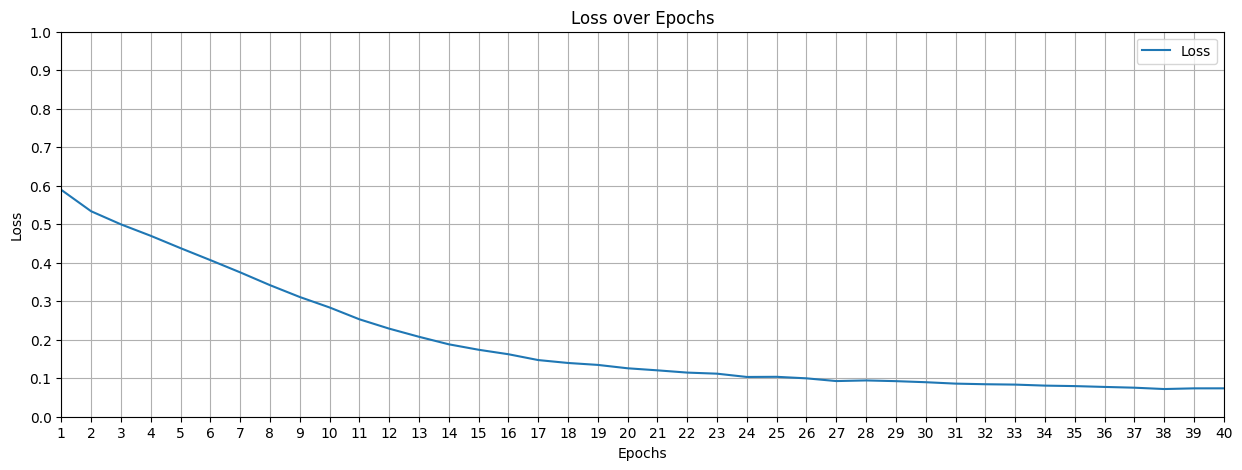

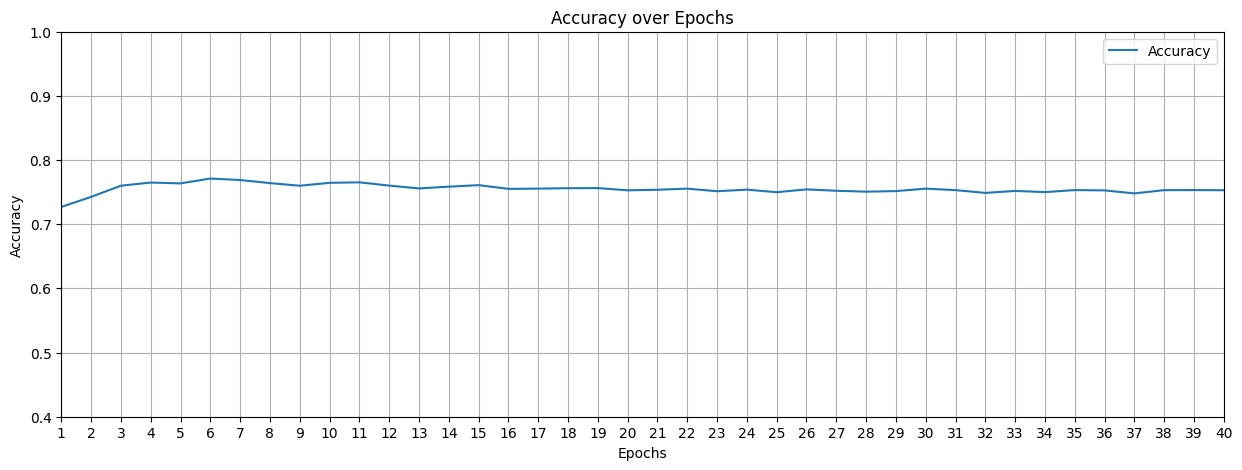

Highest accuracy : 0.7711838942307693 at epoch 6
Confusion matrix of epoch 6:


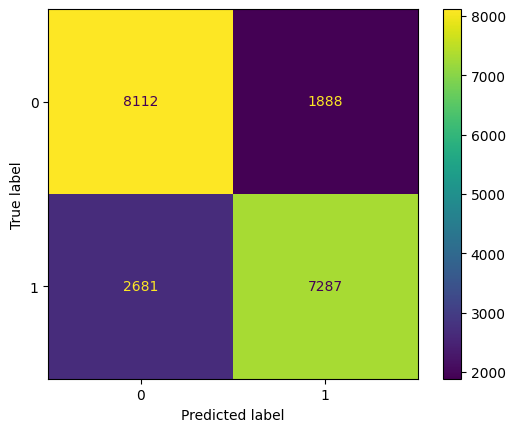

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     10000
           1       0.79      0.73      0.76      9968

    accuracy                           0.77     19968
   macro avg       0.77      0.77      0.77     19968
weighted avg       0.77      0.77      0.77     19968






Loading RGB training data and labels...
Loading RGB testing data and labels...
Training and testing model with ela enhanced with histogram equalization features

Loading ELA Histogram type OpenCV features....

Feature examples :


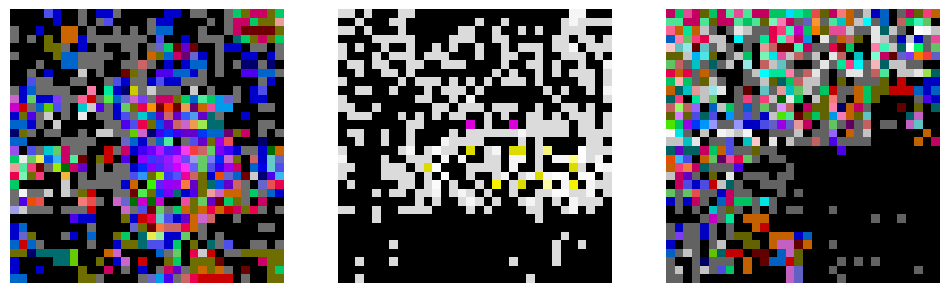

Epoch 1, Loss: 0.501983349095844
Epoch 1, Accuracy: 0.7852564102564102
Epoch 2, Loss: 0.43877033364604895
Epoch 2, Accuracy: 0.8031850961538461
Epoch 3, Loss: 0.4167457293914619
Epoch 3, Accuracy: 0.8092447916666666
Epoch 4, Loss: 0.4007327323457496
Epoch 4, Accuracy: 0.8162059294871795
Epoch 5, Loss: 0.3878385917058217
Epoch 5, Accuracy: 0.8131510416666666
Epoch 6, Loss: 0.3729701596055843
Epoch 6, Accuracy: 0.8146033653846154
Epoch 7, Loss: 0.3588052756807716
Epoch 7, Accuracy: 0.8146534455128205
Epoch 8, Loss: 0.34472507950056835
Epoch 8, Accuracy: 0.821464342948718
Epoch 9, Loss: 0.3284614471558877
Epoch 9, Accuracy: 0.8203125
Epoch 10, Loss: 0.3109872896944515
Epoch 10, Accuracy: 0.8091446314102564
Epoch 11, Loss: 0.29164619841129924
Epoch 11, Accuracy: 0.8142528044871795
Epoch 12, Loss: 0.27466704302423284
Epoch 12, Accuracy: 0.8080428685897436
Epoch 13, Loss: 0.25605188443703475
Epoch 13, Accuracy: 0.8092447916666666
Epoch 14, Loss: 0.23716397415584242
Epoch 14, Accuracy: 0.8107

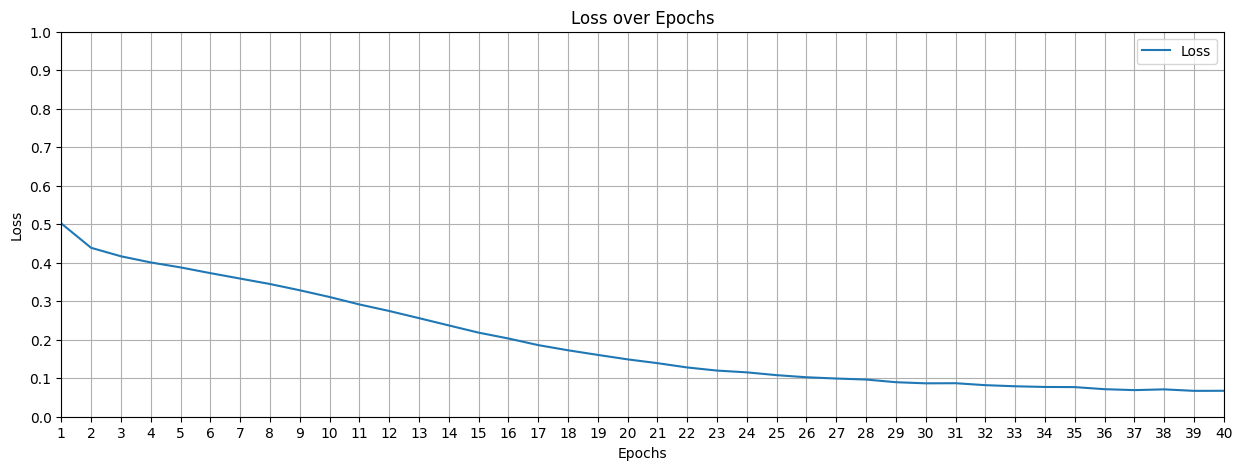

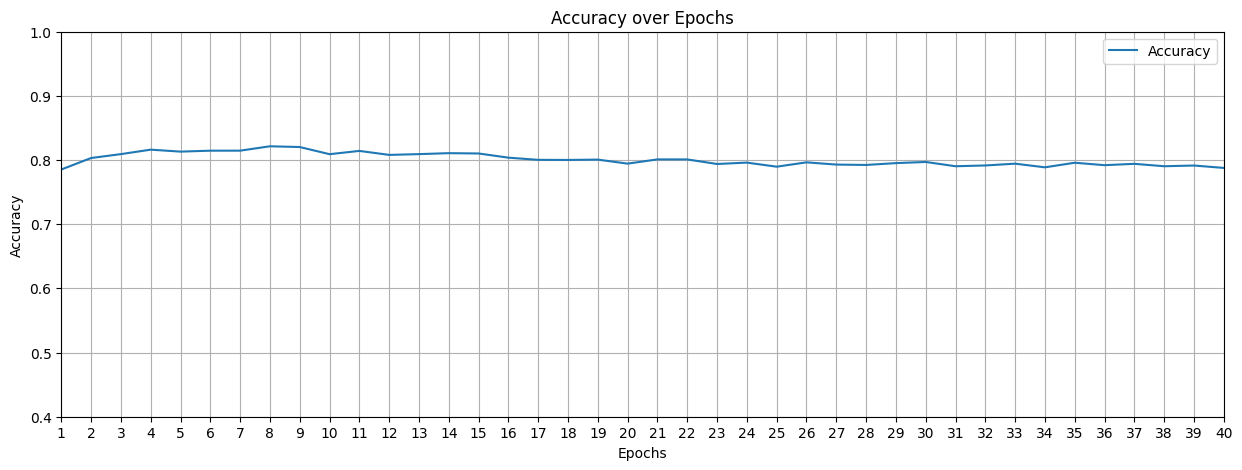

Highest accuracy : 0.821464342948718 at epoch 8
Confusion matrix of epoch 8:


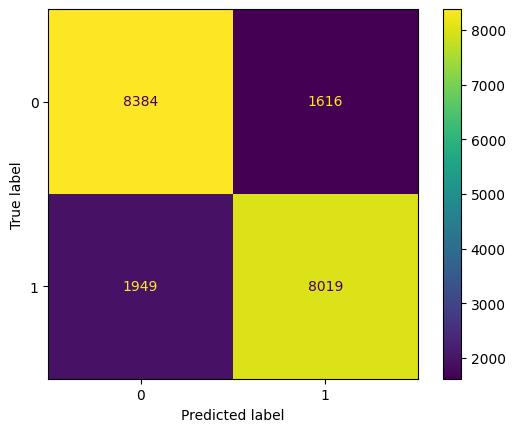

              precision    recall  f1-score   support

           0       0.81      0.84      0.82     10000
           1       0.83      0.80      0.82      9968

    accuracy                           0.82     19968
   macro avg       0.82      0.82      0.82     19968
weighted avg       0.82      0.82      0.82     19968






Loading RGB training data and labels...
Loading RGB testing data and labels...
Training and testing model with ela enhanced with minmax equalization features

Loading ELA MinMax type OpenCV features....

Feature examples :


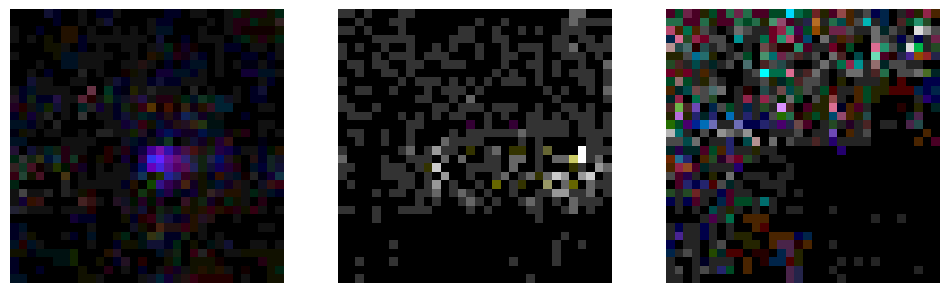

Epoch 1, Loss: 0.5466062130072178
Epoch 1, Accuracy: 0.7629707532051282
Epoch 2, Loss: 0.4773922412823408
Epoch 2, Accuracy: 0.7868589743589743
Epoch 3, Loss: 0.44254548121721315
Epoch 3, Accuracy: 0.7928185096153846
Epoch 4, Loss: 0.4235862878652719
Epoch 4, Accuracy: 0.8100961538461539
Epoch 5, Loss: 0.40714325186533806
Epoch 5, Accuracy: 0.8104467147435898
Epoch 6, Loss: 0.39994220183445855
Epoch 6, Accuracy: 0.8201121794871795
Epoch 7, Loss: 0.39077858603917637
Epoch 7, Accuracy: 0.8167067307692307
Epoch 8, Loss: 0.3796516268681257
Epoch 8, Accuracy: 0.8202123397435898
Epoch 9, Loss: 0.37394970945822886
Epoch 9, Accuracy: 0.821464342948718
Epoch 10, Loss: 0.3651254053299244
Epoch 10, Accuracy: 0.823417467948718
Epoch 11, Loss: 0.35720495810875524
Epoch 11, Accuracy: 0.822265625
Epoch 12, Loss: 0.34873274182661984
Epoch 12, Accuracy: 0.8252203525641025
Epoch 13, Loss: 0.3402179832641895
Epoch 13, Accuracy: 0.8263721955128205
Epoch 14, Loss: 0.32784299361400115
Epoch 14, Accuracy: 0.

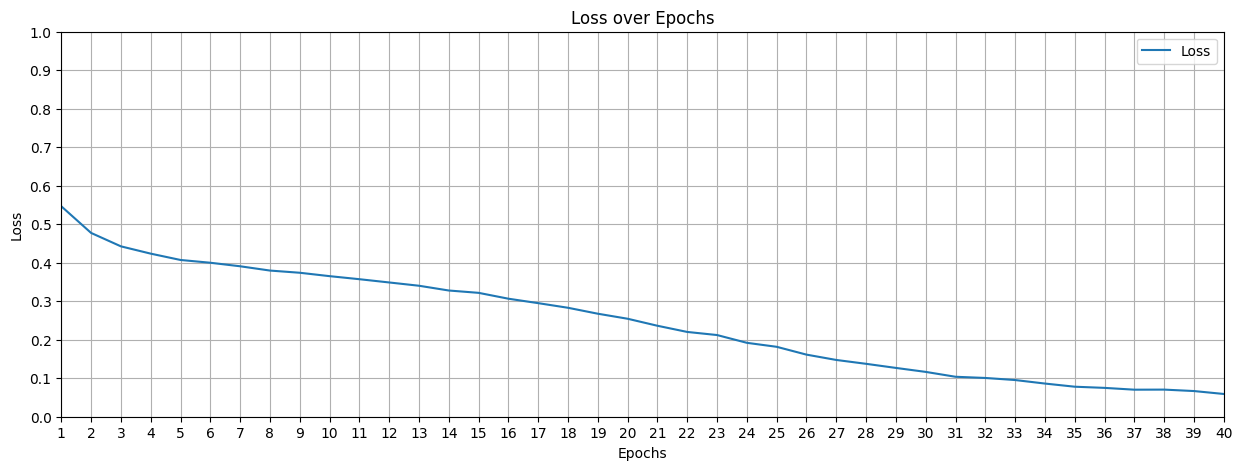

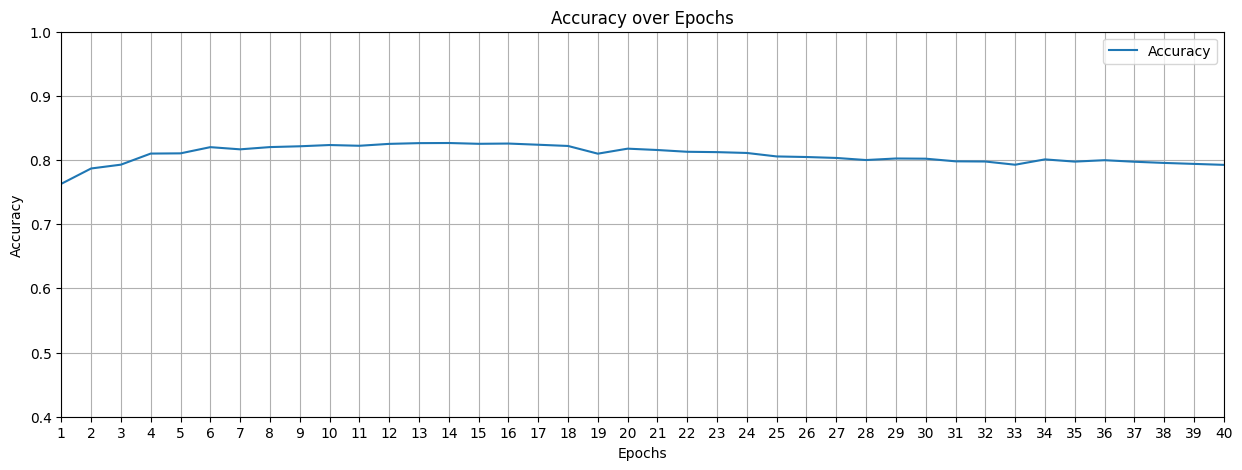

Highest accuracy : 0.8265725160256411 at epoch 14
Confusion matrix of epoch 14:


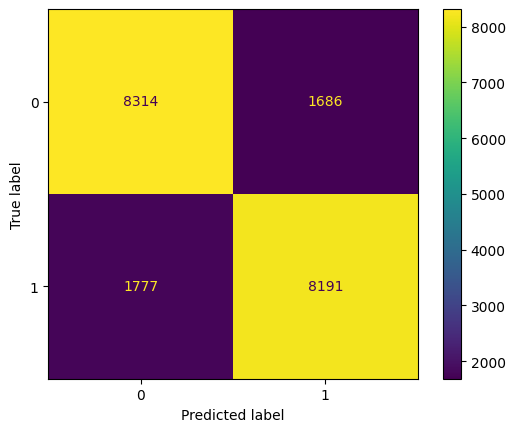

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     10000
           1       0.83      0.82      0.83      9968

    accuracy                           0.83     19968
   macro avg       0.83      0.83      0.83     19968
weighted avg       0.83      0.83      0.83     19968








In [127]:
#############################   CALLING TRAINING AND TESTING LOOP ######################
########## GLOBAL VARIABLES ###########
#### Paths ####
train_data_path = 'data/train'
test_data_path = 'data/test'
data_feature_path = 'Features'

#### Random seed ####
seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

#### Create paths if not present ####
if not os.path.exists(data_feature_path):
    os.mkdir(data_feature_path)
    print(f"Created \"{data_feature_path}\" directory")
    
#### GPU Check ####
print(torch.__version__)
torch.cuda.is_available()

#################  MODEL GENERATION #################
cnn_model1('rgb', batch_size=128, num_epochs=40)
cnn_model1('sobel', batch_size=128, num_epochs=40)
cnn_model1('canny', batch_size=128, num_epochs=40)
cnn_model1('ela_hist', batch_size=128, num_epochs=40)
cnn_model1('ela_minmax', batch_size=512, num_epochs=40)